In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('mint_sections.csv')
# make matrix of assessor x proposals with grade in each cell
# concat assessor and section 
score_matrices = []
for section in df['section'].unique():
    # get all the proposals for this section
    section_df = df[df['section'] == section]
    # get all the assessors for this section
    assessors = section_df['assessor'].unique()
    # create a matrix of assessors x proposals
    matrix = pd.DataFrame(index=assessors, columns=section_df['proposal'].unique())
    # fill the matrix with the grades
    for index, row in section_df.iterrows():
        matrix.at[row['assessor'], row['proposal']] = row['num_grade']
    score_matrices.append(matrix.T)

In [78]:
df.proposal.nunique()  # number of proposals()

353

In [85]:
df.head()

,proposal,Fund,assessor,grade,num_grade,section
0,proposal1_1,1,voter1,A,6,one
1,proposal1_1,1,voter3,A,6,one
2,proposal1_1,1,voter4,A,6,one
3,proposal1_1,1,voter5,A,6,one
4,proposal1_1,1,voter6,A,6,one


In [3]:
# get % of NA that is nan
num_nans = [matrix.isna().sum().sum() for matrix in score_matrices]
num_total = [matrix.size for matrix in score_matrices ]
sum(num_nans) / sum(num_total)

0.10670443814919736

In [4]:
min_score = df.num_grade.min()
max_score = df.num_grade.max()

In [44]:
def manski_median_bounds(scores, min_score, max_score):
    scores = np.asarray(scores, dtype=float)
    m, n = scores.shape
    bounds = np.empty((m, 2), dtype=float)

    for i, row in enumerate(scores):
        isnan = np.isnan(row)
        observed = row[~isnan]
        num_missing = isnan.sum()

        if num_missing == 0:
            bounds[i] = np.median(observed), np.median(observed)
        else:
            low_row = np.where(isnan, min_score, row)
            high_row = np.where(isnan, max_score, row)
            lower = np.median(low_row)
            upper = np.median(high_row)
            bounds[i] = lower, upper

            # Logging for debugging
            # print(f"Row {i}: {num_missing} missing values")
            # print(f"  Observed: {observed}")
            # print(f"  Low imput: {low_row} → median = {lower}")
            # print(f"  High imput: {high_row} → median = {upper}")
            # print(f"  Width: {upper - lower}")

    return bounds


In [72]:
bounds = [manski_median_bounds(matrix.values, min_score, max_score) for matrix in score_matrices]

In [73]:
df_out = pd.DataFrame()
# make a dataframe of the bounds
for i, matrix in enumerate(score_matrices):
    bounds_df = pd.DataFrame(index=matrix.index, columns=['lower', 'upper'])
    bounds_df.loc[matrix.index, 'lower'] = bounds[i][:, 0]
    bounds_df.loc[matrix.index, 'upper'] = bounds[i][:, 1]
    df_out = pd.concat([df_out, bounds_df], axis=0)

In [78]:
df_med = df.groupby(['proposal']).num_grade.median()
# add the median to the dataframe
df_out['median'] = df_med

### Sparsify Data

In [20]:
matrix_sparse = score_matrices[0].copy()
num_to_nan = int((1-0.1) * matrix_sparse.size)
nan_indices = np.random.choice(matrix_sparse.size, num_to_nan, replace=False)
matrix_sparse.values.ravel()[nan_indices] = np.nan

In [17]:
matrix_sparse

,voter1,voter3,voter4,voter5,voter6,voter7,voter8,voter9,voter2
proposal1_1,6,6,6,6,6,6,6,6,NaN
proposal2_1,6,5,6,6,NaN,6,NaN,6,6
proposal3_1,6,NaN,6,6,6,5,5,6,5
proposal4_1,5,6,5,6,6,6,6,5,NaN
proposal5_1,6,6,6,6,5,4,6,NaN,NaN
...,...,...,...,...,...,...,...,...,...
proposal83_1,NaN,2,2,2,2,3,2,2,2
proposal84_1,NaN,2,2,2,2,2,2,2,NaN
proposal85_1,NaN,2,2,2,2,2,2,2,NaN
proposal86_1,2,2,1,1,2,2,2,2,3


In [76]:
def sparsify_matrix(matrix, density):
    """
    Randomly sets entries of a matrix to NaN to achieve a desired density.
    """
    is_df = isinstance(matrix, pd.DataFrame)
    mat = matrix.to_numpy().astype(float) if is_df else matrix.astype(float)
    
    total = mat.size
    num_keep = int(density * total)

    flat_indices = np.arange(total)
    np.random.shuffle(flat_indices)

    mask = np.full(total, False)
    mask[flat_indices[:num_keep]] = True

    mat_flat = mat.ravel()
    mat_flat[~mask] = np.nan

    sparse = mat_flat.reshape(mat.shape)
    return pd.DataFrame(sparse, index=matrix.index, columns=matrix.columns) if is_df else sparse

df_out_sparse = pd.DataFrame()
for density in [0.6, 0.65, 0.7, 0.75, 0.8, 0.85]:
    for iter in range(10):
        for i, matrix in enumerate(score_matrices):
            matrix_sparse = sparsify_matrix(matrix, density)
            bounds = manski_median_bounds(matrix_sparse.values, min_score, max_score)

            bounds_df = pd.DataFrame(index=matrix_sparse.index, columns=['lower', 'upper'])
            bounds_df['lower'] = bounds[:, 0]
            bounds_df['upper'] = bounds[:, 1]
            # get median of each row
            bounds_df['x'] = matrix_sparse.median(axis=1)
            bounds_df['density'] = density
            bounds_df['iter'] = iter
            df_out_sparse = pd.concat([df_out_sparse, bounds_df], axis=0)
        df_out_sparse['x'].fillna((max_score - min_score) / 2., inplace=True)

In [75]:
df_out_sparse.to_csv('manski_bounds_sparse.csv', index=True)

## Plot Data

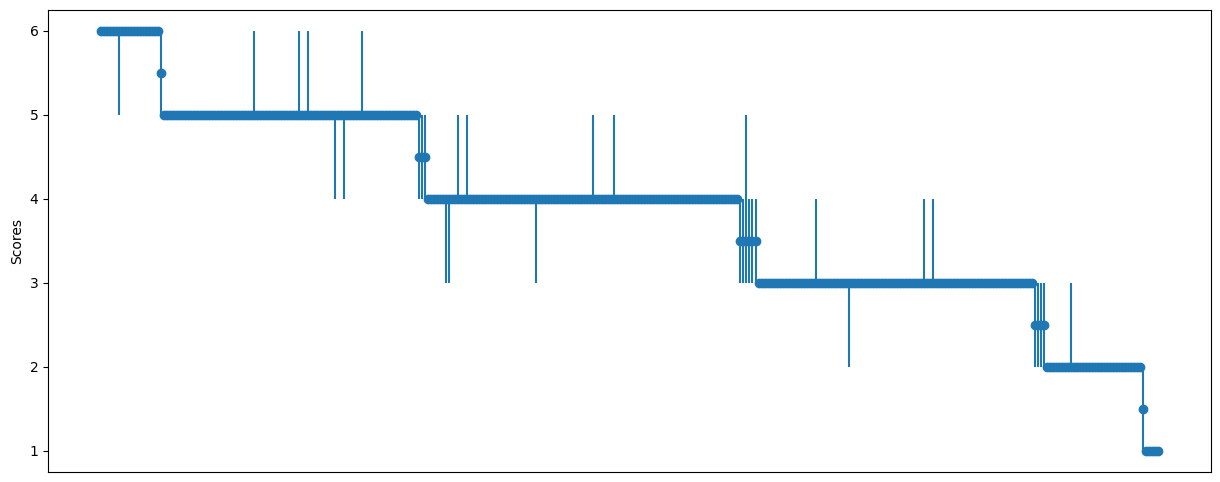

In [89]:
import matplotlib.pyplot as plt

# Sort the dataframe by the median
df_out_sorted = df_out.sort_values(by='median', ascending=False)

# Plot the bounds and median
plt.figure(figsize=(15, 6))
plt.errorbar(df_out_sorted.index, df_out_sorted['median'], 
             yerr=[df_out_sorted['median'] - df_out_sorted['lower'].astype(float), 
                   df_out_sorted['upper'].astype(float) - df_out_sorted['median']], 
             fmt='o')
plt.ylabel('Scores')
# hide x tick labels
plt.xticks([], [])
plt.show()

In [ ]:
df_out.to_csv('manski_intervals.csv')